fatal: destination path 'Face-Mask-Detection' already exists and is not an empty directory.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 62s 436ms/step - accuracy: 0.7892 - loss: 1.8653 - val_accuracy: 0.9682 - val_loss: 0.0894
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.9919 - loss: 0.0238 - val_accuracy: 0.9804 - val_loss: 0.0847
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.9970 - loss: 0.0112 - val_accuracy: 0.9804 - val_loss: 0.0785
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - accuracy: 0.9998 - loss: 0.0041 - val_accuracy: 0.9731 - val_loss: 0.0852
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - accuracy: 0.9998 - loss: 0.0031 - val_accuracy: 0.9780 - val_loss: 0.0752
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9853 - val_loss: 0.0742
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9804 - val_loss: 0.0790
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 1.0000 - loss: 9

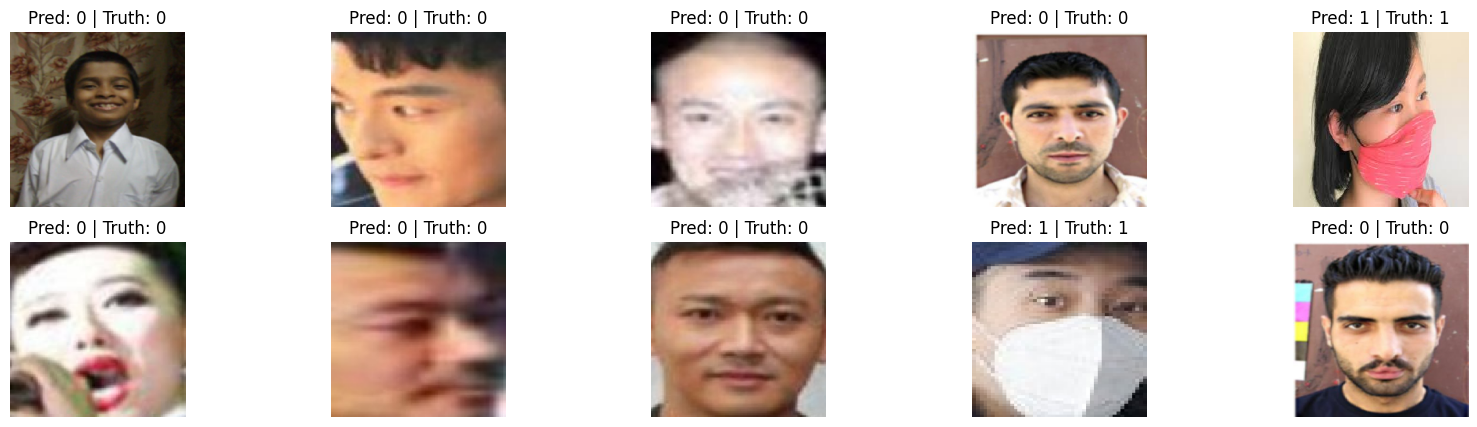

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from io import BytesIO

# Step 1: Load VGG19 Pretrained Model
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 2: Load and Prepare Dataset
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git

dataset_path = "Face-Mask-Detection/dataset"
with_mask_path = os.path.join(dataset_path, 'with_mask')
without_mask_path = os.path.join(dataset_path, 'without_mask')

images = []
labels = []

for img_name in os.listdir(with_mask_path):
    img_path = os.path.join(with_mask_path, img_name)
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img = tf.keras.utils.img_to_array(img)
    images.append(img)
    labels.append(1)  # Label 1 for 'with_mask'

for img_name in os.listdir(without_mask_path):
    img_path = os.path.join(without_mask_path, img_name)
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img = tf.keras.utils.img_to_array(img)
    images.append(img)
    labels.append(0)  # Label 0 for 'without_mask'

images = np.array(images) / 255.0
labels = np.array(labels)

# Splitting the dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Train the Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the model
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Show the first 10 test images with predictions
predictions = np.argmax(model.predict(X_test[:10]), axis=1)
truth = y_test[:10]

plt.figure(figsize=(20, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i])
    plt.title(f"Pred: {predictions[i]} | Truth: {truth[i]}")
    plt.axis('off')
plt.show()

In [ ]:
# Step 4: Classify External Images

def classify_image(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).resize((224, 224))
    img_array = np.array(img) / 255.0
    if len(img_array.shape) == 2:  # Grayscale to RGB
        img_array = np.stack((img_array,)*3, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = np.argmax(model.predict(img_array), axis=1)
    return \"with_mask\" if prediction\[0\] == 1 else \"without_mask\"

# Test the function with an external image URL
image_url = "<your_image_url_here>"
print(f"The image is classified as: {classify_image(image_url)}")